## Load in vivo data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import os
from tqdm import tqdm

from cell_inference.config import paths, params
from cell_inference.utils.feature_extractors.SummaryStats2D import process_lfp

invivo_name = 'all_cell_LFP2D_Analysis_SensorimotorSpikeWaveforms_NP_SUTempFilter_NPExample'
# invivo_name = 'all_cell_LFP2D_Analysis_SensorimotorSpikes_NPUnits_large.h5'

INVIVO_PATH = 'cell_inference/resources/invivo'
DATA_PATH = os.path.join(INVIVO_PATH, invivo_name + '.h5')
LFP_PATH = os.path.join(INVIVO_PATH, 'lfp_' + invivo_name + '.npz')  # LFP and labels
STATS_PATH = os.path.join(INVIVO_PATH, 'summ_stats_' + invivo_name + '.npz')  # summary statistics

save_lfp = False
save_stats = False

In [2]:
with h5py.File(DATA_PATH,'r') as hf:
    elec_pos = hf['coord'][()]
    lfp = 1e-3 * hf['data'][()].transpose((0,2,1)) # (samples x channels x time) -> (samples x time x channels), uV -> mV
    IDs = hf['ID'][()]
    if 'layer' in hf:
        layer_type = {i[0]: name for name, i in hf['layer'].attrs.items()}
        layer = np.array([layer_type[i] for i in hf['layer']])
    else:
        layer = np.full(lfp.shape[0], 'N/A')

## Process LFP

In [3]:
if save_lfp or save_stats:
    pad_spike_window = False
    bad_cases = tuple(range(-1,3)) if pad_spike_window else tuple(range(3))

    bad_indices = {bad: [] for bad in bad_cases}
    lfp_list = []
    coord = []
    ycenter = []
    summ_stats = []

    for i in tqdm(range(lfp.shape[0])):
        bad, g_lfp, _, g_coords, y_c, _, ss = process_lfp(lfp[i], coord=elec_pos, dt=None, gauss_filt=True,
                                                   calc_summ_stats=save_stats, additional_stats=2, err_msg=True)
        bad_indices[bad].append(i)
        if bad<=0:
            lfp_list.append(g_lfp)
            coord.append(g_coords)
            ycenter.append(y_c)
            if save_stats:
                summ_stats.append(ss)

    t = params.DT * np.arange(params.WINDOW_SIZE)
    windowed_lfp = np.stack(lfp_list, axis=0)  # (samples x time window x channels)
    coord = np.stack(coord, axis=0)
    ycenter = np.array(ycenter)
    summ_stats = np.array(summ_stats)

    bad_idx = np.array([i for bad, indices in bad_indices.items() if bad>0 for i in indices])
    good_indices = np.sort([i for bad, indices in bad_indices.items() if bad<=0 for i in indices])
    print('%d good samples out of %d samples.' % (good_indices.size, lfp.shape[0]))
    for bad, indices in bad_indices.items():
        print('Bad case %d bad: %d samples.' % (bad, len(indices)))

## Save results

In [4]:
if save_lfp:
    np.savez(LFP_PATH, t=t, x=windowed_lfp, coord=coord, yc=ycenter, layer=layer,
             bad_indices=bad_indices, good_indices=good_indices)
if save_stats:
    np.savez(STATS_PATH, x=summ_stats, yc=ycenter, layer=layer[good_indices])

## Check LFP amplitude decay

In [5]:
lfp_list = np.load(LFP_PATH)['x']
summ_stats = np.load(STATS_PATH)['x']
layer = np.load(STATS_PATH)['layer']
good_indices = np.load(LFP_PATH)['good_indices']

dy = np.diff(params.ELECTRODE_GRID[1][:2])[0]
decay_stats = dy * summ_stats[:, -8:]
decay_name = np.array(['tr_lambda_l', 'tr_lambda_r', 'tr_slope_l', 'tr_slope_r',
                       'pk_lambda_l', 'pk_lambda_r', 'pk_slope_l', 'pk_slope_r'])
decay_dict = {name: decay_stats[:, i] for i, name in enumerate(decay_name)}
df_decay = pd.DataFrame(decay_dict, index=IDs[good_indices])
df_decay['layer'] = layer
layer_idx = {L: np.nonzero(layer==L)[0] for L in np.unique(layer)}
sort_idx = np.argsort(np.array([idx.size for idx in layer_idx.values()]))[::-1]
layer_idx = dict(zip(np.asarray(list(layer_idx.keys()))[sort_idx], np.asarray(list(layer_idx.values()), dtype=object)[sort_idx]))

#### Distributions of decay length constant

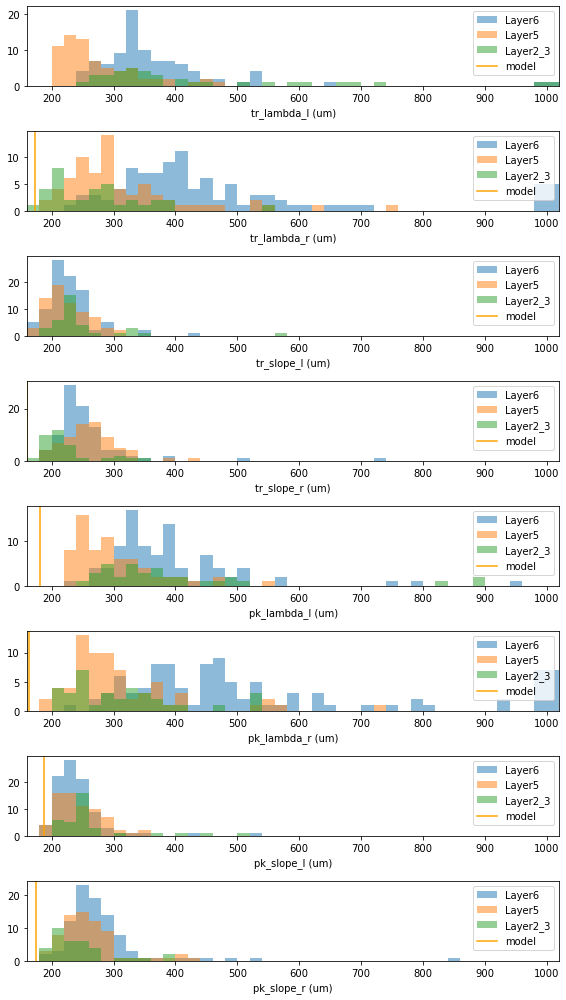

In [6]:
%matplotlib inline

bin_max = 50
bin_min = int(np.floor(np.amin(decay_stats) / dy))
bins = np.append(dy * np.arange(bin_min, bin_max), np.amax(decay_stats))

# Baseline: Long trunk = 845 um, R = 1.27 um, g_Ca = 0, h = 1
# example_decay = '[159.85236571 259.85499107 152.29735141 220.63571681 153.11734412 186.71465362 177.98086139 198.61188113]'

# high g_Ca = 3.5 x g_leak
# example_decay = '[160.89414206 269.64089959 154.43840114 216.58320007 158.76555772 199.95192193 180.63385505 213.70307144]'

# thin mid trunk R = 0.8 um
example_decay = '[154.06072634 173.66256666 143.81147155 160.64192185 180.54980095 162.69670286 186.86432643 175.3706075]'

# Short trunk = 5 um
# example_decay = '[156.65895355 217.65670653 147.75082179 188.28481118 158.25794157 173.04326338 174.13922093 183.68921334]'

# Orientation h = 0.9
# example_decay = '[161.28460489 156.16263227 165.71461537 149.07170661 127.86058627 306.0548489 143.15319122 230.22268954]'

example_decay = np.array(eval(example_decay.replace(' ', ','))).ravel()

plt.figure(figsize=(8, 14))
for i, name in enumerate(decay_name):
    plt.subplot(decay_name.size, 1, i + 1)
    for L, idx in layer_idx.items():
        plt.hist(decay_dict[name][idx], bins=bins, label=L, alpha=0.5)
    plt.axvline(x=example_decay[i], color='orange', label='model')
    plt.xlim([bins[0], bins[-2] + bins[2] - bins[0]])
    plt.xlabel(name + ' (um)')
    plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# sort by selected feature
df_decay = df_decay.sort_values('tr_lambda_r')
# pd.set_option('display.max_rows', None)
display(df_decay)

,tr_lambda_l,tr_lambda_r,tr_slope_l,tr_slope_r,pk_lambda_l,pk_lambda_r,pk_slope_l,pk_slope_r,layer
537,294.211866,175.113973,198.235652,181.292310,250.806315,219.022427,206.014518,196.379331,Layer2_3
312,367.153599,189.649018,231.424294,191.288079,319.478704,237.792570,242.312810,222.720575,Layer2_3
546,314.029066,190.849710,202.382315,186.758368,290.940513,205.460890,224.280649,188.882201,Layer2_3
258,208.475317,194.024585,190.311636,200.201397,244.458734,198.604229,211.856805,205.613066,Layer5
259,234.202598,196.450885,191.363684,201.484201,292.648765,196.362368,220.827139,191.931582,Layer5
...,...,...,...,...,...,...,...,...,...
407,534.646455,1113.381891,420.721295,733.437739,796.412691,2969.528947,537.395420,850.680793,Layer6
88,366.433598,1176.493307,193.373385,228.304200,338.846346,2145.130189,221.668452,271.308692,Layer6
503,529.661351,1227.887038,274.575133,319.650099,471.324627,781.537292,224.153917,261.848910,Layer6
501,655.128130,1522.066427,299.183782,393.643134,470.694731,1169.547105,205.239241,286.150037,Layer6


 #### Check decay of LFP magnitude of all cells

In [8]:
import cell_inference.utils.feature_extractors.SummaryStats2D as ss

grid_shape = (ss.GRID_SHAPE[0], int(lfp_list.shape[2]/ss.GRID_SHAPE[0]))
def get_relative_decay(lfp, relative=True):
    t_t, t_p, troughs, peaks = ss.get_tr_pk(lfp)
    y_troughs = ss.get_max_val_y(troughs, grid_shape)
    y_peaks = ss.get_max_val_y(peaks, grid_shape)
    if relative:
        y_troughs = np.log(y_troughs)
        y_peaks = np.log(y_peaks)
        y_troughs -= np.amax(y_troughs)
        y_peaks -= np.amax(y_peaks)
    else:
        y_troughs *= 1000
        y_peaks *= 1000
    return t_t, t_p, y_troughs, y_peaks

In [9]:
y_trouhgs_list = np.empty((lfp_list.shape[0], grid_shape[1]))
y_peaks_list = np.empty((lfp_list.shape[0], grid_shape[1]))
for i, lfp in enumerate(lfp_list):
    _, _, y_troughs, y_peaks = get_relative_decay(lfp)
    y_trouhgs_list[i] = y_troughs
    y_peaks_list[i] = y_peaks

rel_y = dy * (np.arange(grid_shape[1]) - int(grid_shape[1]/2))

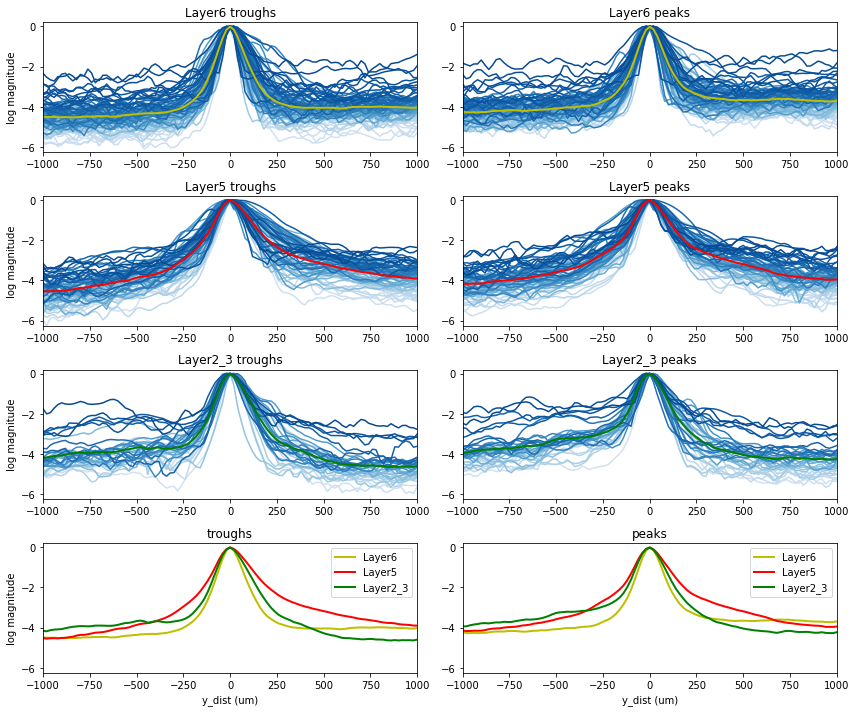

In [10]:
n_layer = len(layer_idx)
sort_name = 'slope_r'
mm = min(np.amin(y_trouhgs_list), np.amin(y_peaks_list))

plt.figure(figsize=(12, 10))
layer_clr = ['y','r','g']
for i, (L, idx) in enumerate(layer_idx.items()):
    y_troughs_m = np.mean(y_trouhgs_list[idx], axis=0)
    y_peaks_m = np.mean(y_peaks_list[idx], axis=0)
    
    cycler = plt.cycler('color', plt.cm.Blues(np.linspace(0.2, .9, len(idx))))
    plt.subplot(n_layer + 1, 2, i * 2 + 1)
    plt.gca().set_prop_cycle(cycler)
    sort_idx = np.argsort(decay_dict['tr_' + sort_name][idx])
    plt.plot(rel_y, y_trouhgs_list[idx[sort_idx]].T)
    plt.plot(rel_y, y_troughs_m, color=layer_clr[i], linewidth=2)
    plt.xlim(rel_y[[0, -1]])
    plt.ylim([mm, 0.2])
    plt.title(L + ' troughs')
    plt.ylabel('log magnitude')
    
    plt.subplot(n_layer + 1, 2, i * 2 + 2)
    plt.gca().set_prop_cycle(cycler)
    sort_idx = np.argsort(decay_dict['pk_' + sort_name][idx])
    plt.plot(rel_y, y_peaks_list[idx[sort_idx]].T)
    plt.plot(rel_y, y_peaks_m, color=layer_clr[i], linewidth=2)
    plt.xlim(rel_y[[0, -1]])
    plt.ylim([mm, 0.2])
    plt.title(L + ' peaks')
    
    plt.subplot(n_layer + 1, 2, n_layer * 2 + 1)
    plt.plot(rel_y, y_troughs_m, color=layer_clr[i], linewidth=2, label=L)
    plt.xlim(rel_y[[0, -1]])
    plt.ylim([mm, 0.2])
    plt.title('troughs')
    plt.ylabel('log magnitude')
    plt.xlabel('y_dist (um)')
    plt.legend()
    
    plt.subplot(n_layer + 1, 2, n_layer * 2 + 2)
    plt.plot(rel_y, y_peaks_m, color=layer_clr[i], linewidth=2, label=L)
    plt.xlim(rel_y[[0, -1]])
    plt.ylim([mm, 0.2])
    plt.title('peaks')
    plt.xlabel('y_dist (um)')
    plt.legend()
plt.tight_layout()
plt.show()

#### Check decay of LFP magnitude of selected cell and plot its LFP

In [11]:
select_ID = 199 # 281
select_id = np.nonzero(IDs[good_indices]==select_ID)[0][0]


lfp = lfp_list[good_indices[select_id]]
t = np.load(LFP_PATH)['t']
coords = np.load(LFP_PATH)['coord'][good_indices[select_id]]
print(layer[select_id])

t_t, t_p, y_troughs, y_peaks = get_relative_decay(lfp, relative=False)
lambda_troughs = ss.get_decay(y_troughs)
lambda_peaks = ss.get_decay(y_peaks)

np.set_printoptions(suppress=True)
print('Length constant (um) of troughs / peaks: \n  by lambda (left, right), by slope (left, right)')
print(dy * np.array([lambda_troughs, lambda_peaks]))

Layer5
Length constant (um) of troughs / peaks: 
  by lambda (left, right), by slope (left, right)
[[246.49145564 319.81778666 219.02014242 297.83622332]
 [310.05828409 302.70695313 248.25405417 261.21889021]]


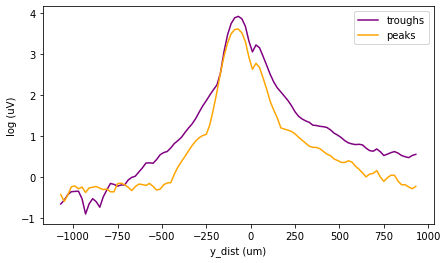

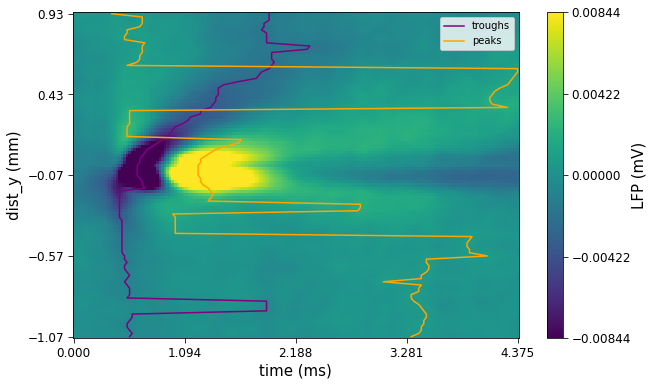

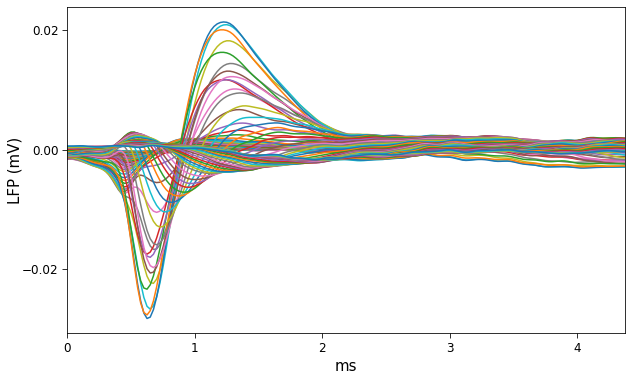

In [12]:
from cell_inference.utils.plotting.plot_results import plot_lfp_heatmap, plot_lfp_traces
%matplotlib inline

ix = 1
fontsize = 15
labelpad = 0
ticksize = 12
tick_length = 5
nbins = 5

x_dist = np.unique(coords[:, 0])
e_idx = coords[:, 0]==x_dist[ix]

plt.figure(figsize=(7,4))
plt.plot(coords[e_idx, 1], np.log(y_troughs), color='purple', label='troughs')
plt.plot(coords[e_idx, 1], np.log(y_peaks), color='orange', label='peaks')
plt.xlabel('y_dist (um)')
plt.ylabel('log (uV)')
plt.legend()

plt.figure(figsize=(10,6))
_ = plot_lfp_heatmap(t=t, elec_d=coords[e_idx, 1], lfp=lfp[:, e_idx],
                     fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                     nbins=nbins, vlim='auto', axes=plt.gca())
plt.plot(t[t_t[e_idx]], coords[e_idx, 1]/1000, color='purple', label='troughs')
plt.plot(t[t_p[e_idx]], coords[e_idx, 1]/1000, color='orange', label='peaks')
plt.legend()

plt.figure(figsize=(10,6))
_ = plot_lfp_traces(t, lfp[:, e_idx], # electrodes=coords[e_idx, :],
                    fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                    nbins=nbins, axes=plt.gca())
plt.show()

#### Apply log modulus transform to see small magnitude features

In [13]:
from cell_inference.utils.transform.data_transform import log_modulus

n_fold = 30
max_logmod = np.ceil(np.log2(n_fold))  # max value after transform
n_fold = 2**max_logmod - 1
ref_mag = np.amax(np.abs(lfp)) / n_fold
print('Maximum magnitude is %d-fold reference magnitude %.3g mV.' % (n_fold, ref_mag))
lfp_logmod = log_modulus(lfp, ref_mag)

Maximum magnitude is 31-fold reference magnitude 0.00162 mV.


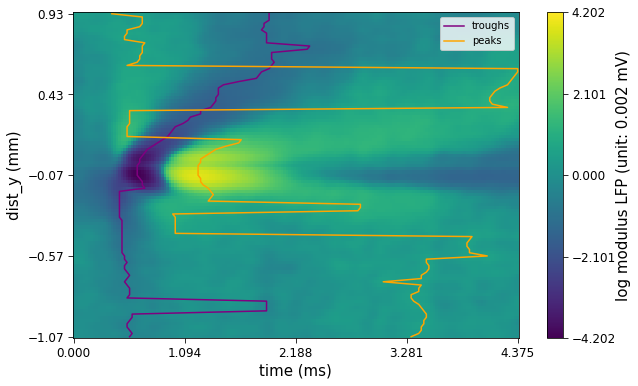

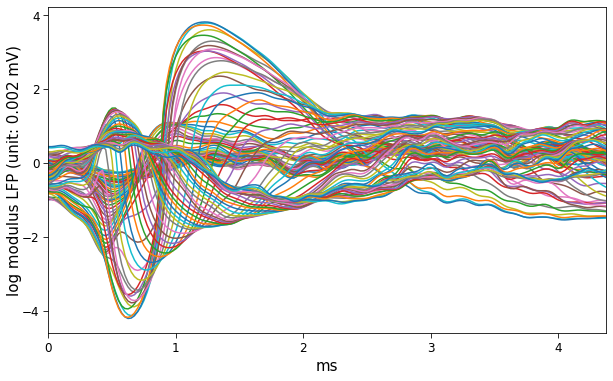

In [14]:
lfp_label = 'log modulus LFP (unit: %.g mV)' % (ref_mag)

plt.figure(figsize=(10,6))
_ = plot_lfp_heatmap(t=t, elec_d=coords[e_idx, 1], lfp=lfp_logmod[:, e_idx],
                     fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                     nbins=nbins, vlim='max', colorbar_label=lfp_label, axes=plt.gca())
plt.plot(t[t_t[e_idx]], coords[e_idx, 1]/1000, color='purple', label='troughs')
plt.plot(t[t_p[e_idx]], coords[e_idx, 1]/1000, color='orange', label='peaks')
plt.legend()

plt.figure(figsize=(10,6))
_ = plot_lfp_traces(t, lfp_logmod[:, e_idx], # electrodes=coords[e_idx, :], vlim='max',
                    fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                    nbins=nbins, axes=plt.gca())
plt.gca().set_ylabel(lfp_label)

plt.show()